# Imports and pre processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [ ]:
data_path = '/content/drive/MyDrive/School/NLP/ireland-news-headlines.csv'
data = pd.read_csv(data_path)
data.head()

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


In [ ]:
# converting the date into date format
data['publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
data.head()

,publish_date,headline_category,headline_text
0,1996-01-02,news,UUP sees possibility of voting Major out
1,1996-01-02,news,Pubs targeted as curbs on smoking are extended
2,1996-01-02,news,Papers reveal secret links with O'Neill cabinet
3,1996-01-02,news,Domestic chaos as Italy takes EU presidency
4,1996-01-02,news,Learning about the star to which we owe life


In [ ]:
print(data.publish_date.min())
print(data.publish_date.max())

1996-01-02 00:00:00
2021-06-30 00:00:00


In [ ]:
data.isna().sum() #if something is different than 0, there are nulls that we need to handle

publish_date         0
headline_category    0
headline_text        7
dtype: int64

In [ ]:
# erase the rows w/o headline text
data = data[data.headline_text.notna()]
data.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
print(data['headline_category'].nunique())
print(data['headline_category'].unique())

103
['news' 'culture' 'opinion' 'opinion.letters' 'business' 'sport'
 'news.health' 'news.education' 'lifestyle.homes'
 'news.politics.oireachtas' 'culture.media' 'news.world.europe'
 'lifestyle.motors' 'sport.soccer' 'sport.racing' 'sport.rugby'
 'culture.tuarascail' 'business.commercial-property' 'culture.music'
 'lifestyle' 'culture.tv-radio-web' 'news.consumer' 'news.science'
 'news.law' 'lifestyle.travel' 'culture.books' 'culture.stage'
 'lifestyle.people' 'lifestyle.health-family' 'culture.film'
 'culture.design' 'news.environment' 'lifestyle.travel.europe'
 'lifestyle.travel.long-haul' 'lifestyle.travel.ireland'
 'lifestyle.fashion' 'lifestyle.homes.new-to-market'
 'culture.music.album-reviews' 'lifestyle.food' 'lifestyle.food.drink'
 'lifestyle.food.restaurant' 'lifestyle.health-family.fitness'
 'culture.game-reviews' 'news.social.beliefs' 'business.technology'
 'business.financial-services' 'business.economy.ireland'
 'business.retail-and-services' 'business.economy.public-fin

In [ ]:
# check what is the highest number of sub categories
x = data['headline_category'].unique()
max_cat = -1
for cat in x:
  cat = cat.split('.')
  cur_len = len(cat)
  if cur_len > max_cat:
    max_cat = cur_len
print(max_cat)

4


since the highest number of categories is 4 per article, we will open 4 more columns that will hold the sub categories of each article. We are assuming that the first category is the main one.

In [ ]:
data[['category1', 'category2', 'category3', 'category4']] = data['headline_category'].str.split('.', expand=True)
# Fill missing values with NaN
data[['category1', 'category2', 'category3', 'category4']] = data[['category1', 'category2', 'category3', 'category4']].fillna('')
data.tail()

,publish_date,headline_category,headline_text,category1,category2,category3,category4
1611490,2021-06-30,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...,news,politics,oireachtas,
1611491,2021-06-30,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,culture,,,
1611492,2021-06-30,sport.others,Andy Murray rolls back the years to own Centre...,sport,others,,
1611493,2021-06-30,news.health,Delta variant could do 'significant damage' in...,news,health,,
1611494,2021-06-30,culture,Gordon Brown: 'We've got to give people a mess...,culture,,,


# Part A

## Text Analysis

In [ ]:
# number of words in headline text
data['word_count'] = data['headline_text'].str.split().str.len() #split by space so that it counts number of words
data.word_count.unique()

array([ 7,  8,  9,  6,  5, 11, 10, 12, 15,  3,  4,  2,  1, 14, 13, 24, 22,
       29, 17, 16, 19, 23, 18, 25, 21, 32, 20, 33, 27, 26, 28, 42, 34, 38,
       31, 35, 44, 30, 39, 41, 37])

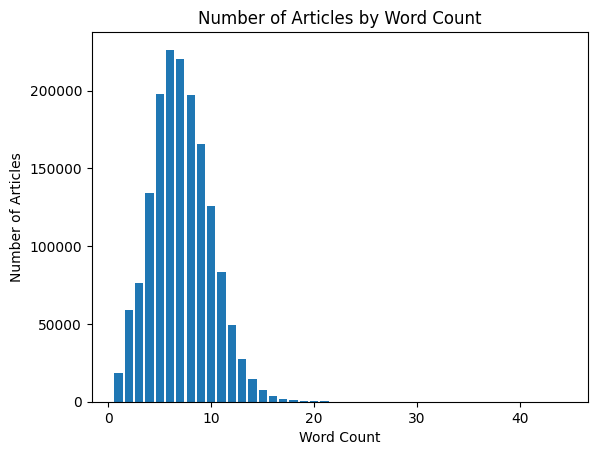

In [ ]:
word_count_dist = data.groupby('word_count').agg(num_articles=('word_count', 'size')).reset_index()
plt.bar(word_count_dist['word_count'], word_count_dist['num_articles'])
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.title('Number of Articles by Word Count')

plt.show()

## Main Categories Analysis

checking that sub categories that go along with each of the main categories

In [ ]:
data['category1'].unique()

array(['news', 'culture', 'opinion', 'business', 'sport', 'lifestyle'],
      dtype=object)

In [ ]:
def sub_per_main(main, df):
  """
  this function recieves a main category and plots a bar chart of all of it's subcategories
  """
  main_df = df[df.category1==main]

  # Extract unique subcategories from 'category2', 'category3', and 'category4'. ignore NA values
  subcategories = list(pd.unique(main_df[['category2', 'category3', 'category4']].values.ravel()))
  subcategories = [value for value in subcategories if value != '']

  # Extract the number of times each of the subcategories appears overall (in all 3 sub columns)
  count_sub = []
  for sub in subcategories:
    cur_sum = 0
    cur_sum+=main_df[main_df.category2==sub].shape[0]
    cur_sum+=main_df[main_df.category3==sub].shape[0]
    cur_sum+=main_df[main_df.category4==sub].shape[0]
    count_sub.append(cur_sum)

  # Print statistics for this main
  print(f'The number of times "{main.capitalize()}" appeared in the data as main category: {main_df.shape[0]:,}')
  print(f"The number of subcategories: {len(subcategories)}")

  # Create a plot of unique subcategories
  plt.figure(figsize=(8, 6))
  plt.bar(subcategories, count_sub)
  plt.xlabel('Subcategories')
  plt.ylabel('Count')
  plt.title(f'Unique Subcategories for "{main.capitalize()}" in Category 1')
  plt.xticks(rotation=90)
  plt.show()

The number of times "News" appeared in the data as main category: 798,680
The number of subcategories: 28


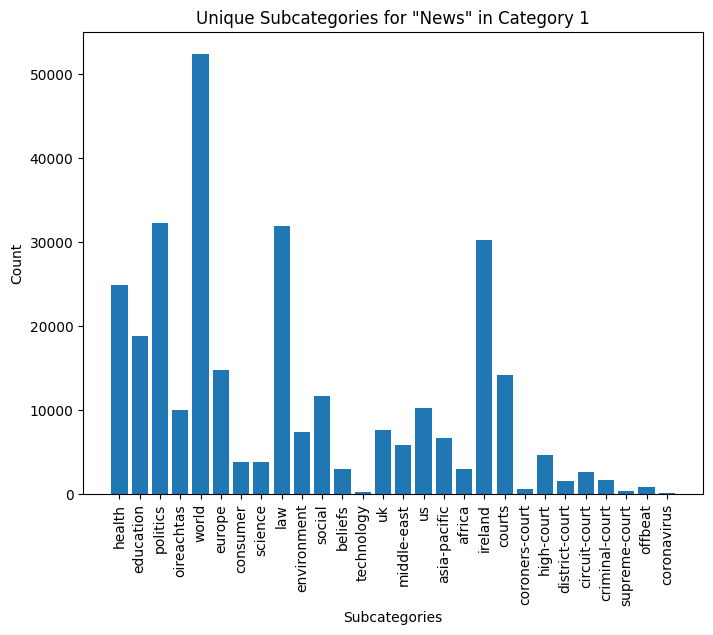

In [ ]:
sub_per_main(data['category1'].unique()[0], data)

The number of times "Culture" appeared in the data as main category: 98,944
The number of subcategories: 12


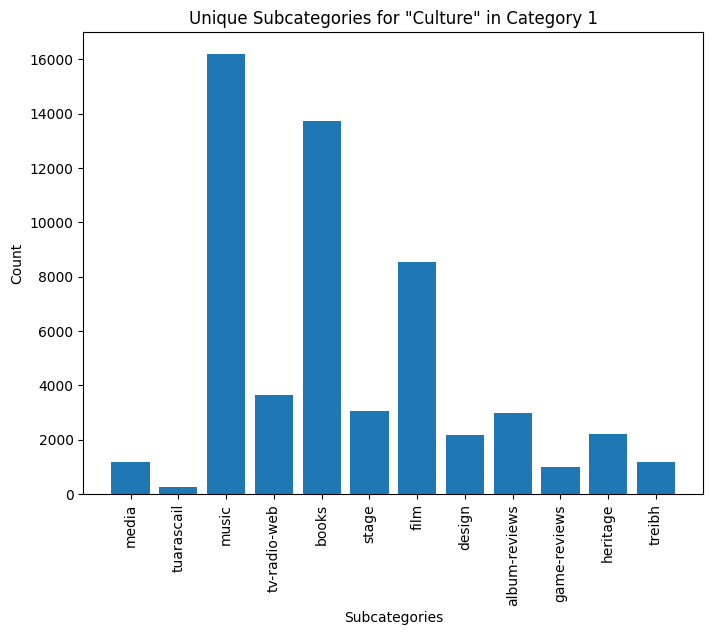

In [ ]:
sub_per_main(data['category1'].unique()[1], data)

The number of times "Opinion" appeared in the data as main category: 133,073
The number of subcategories: 2


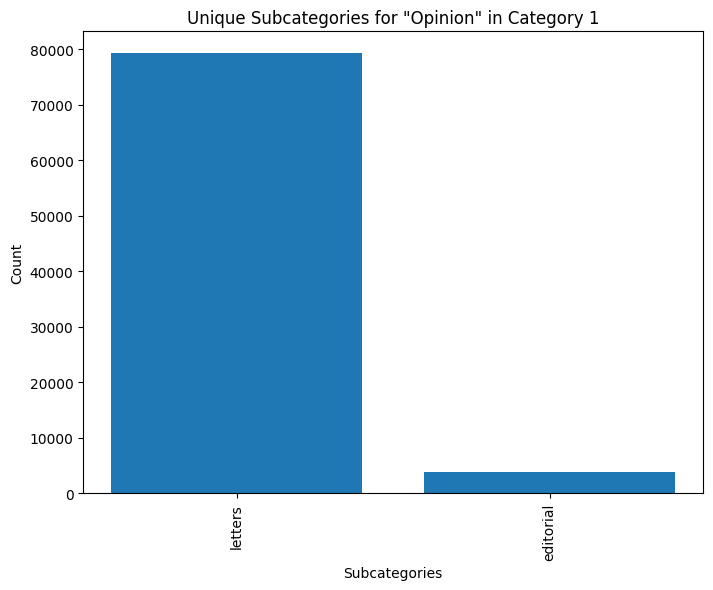

In [ ]:
sub_per_main(data['category1'].unique()[2], data)

The number of times "Business" appeared in the data as main category: 222,960
The number of subcategories: 24


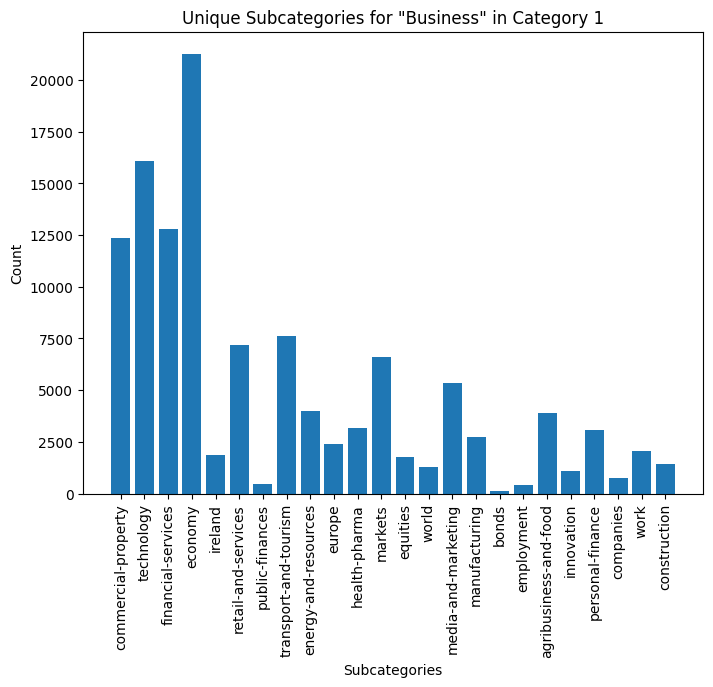

In [ ]:
sub_per_main(data['category1'].unique()[3], data)

The number of times "Sport" appeared in the data as main category: 261,826
The number of subcategories: 6


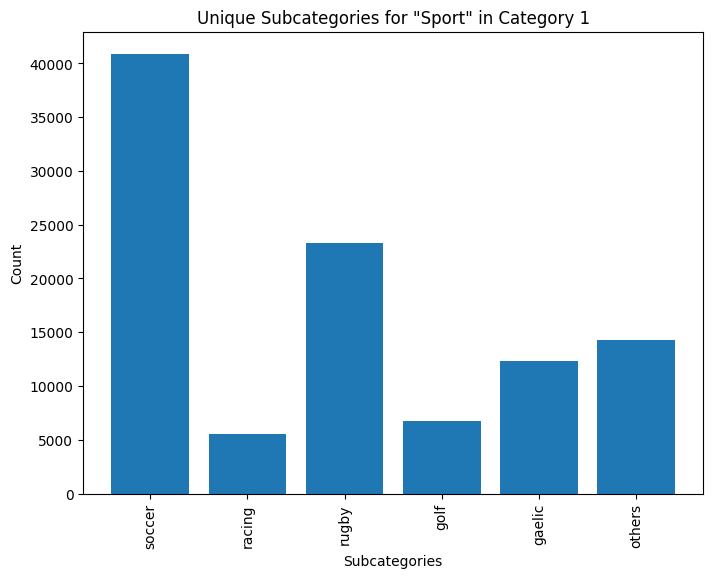

In [ ]:
sub_per_main(data['category1'].unique()[4], data)

The number of times "Lifestyle" appeared in the data as main category: 96,005
The number of subcategories: 25


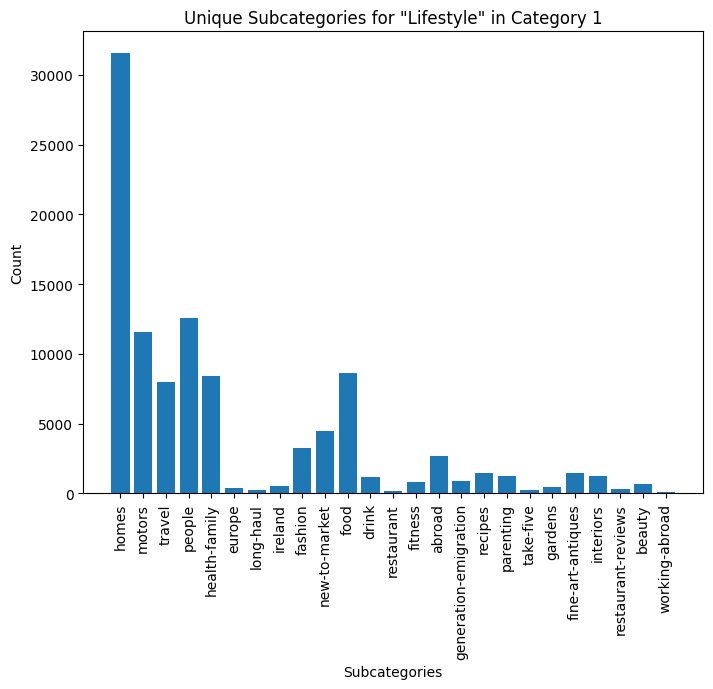

In [ ]:
sub_per_main(data['category1'].unique()[5], data)

In [ ]:
def category_counts(cat_col, df):
  """
  cat_col = which category column we are checking (category1/category2 etc..)
  this function creates a pie chart comparing the % of each category.
  """
  category_counts = df[cat_col].value_counts()

  # Create a pie chart
  plt.figure(figsize=(8, 6))
  plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
  plt.title(f'Occurrences of Unique Values in {cat_col}\n\n')
  plt.axis('equal')
  plt.show()

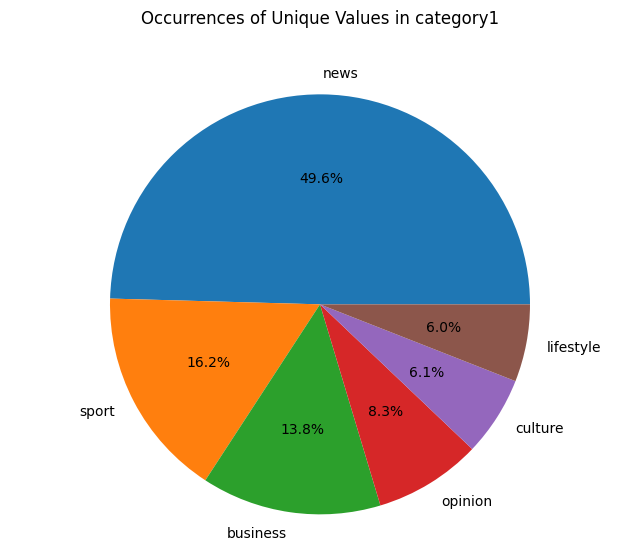

In [ ]:
# plot how many times each of the main categories appears as main
category_counts('category1', data)

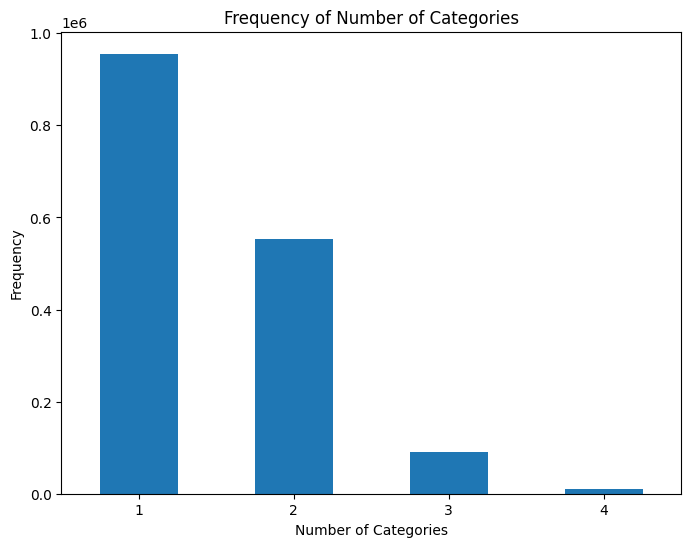

In [ ]:
# Count the number of non-NA values in each row
category_count = data[['category1', 'category2', 'category3', 'category4']].apply(lambda x: sum(x != ''), axis=1)

# Count the frequency of each category count
category_count_freq = category_count.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
category_count_freq.plot(kind='bar')
plt.xlabel('Number of Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Categories')
plt.xticks(rotation=0)
plt.show()

## Dates Analysis

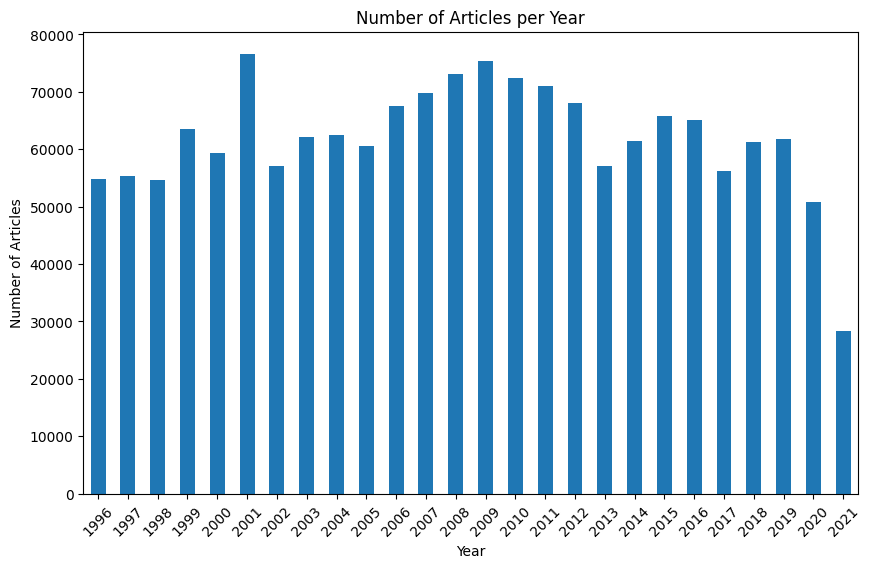

In [ ]:
data['year'] = pd.to_datetime(data['publish_date'], format='%Y%m%d').dt.year

# Count the number of rows for each year
yearly_counts = data['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Year')
plt.xticks(rotation=45)
plt.show()

it seems like there is a surge in the number of articles in 2001. We think it has something to do with 9/11, lets check the top topics in that year:

The number of times "News" appeared in the data as main category: 48,128
The number of subcategories: 4


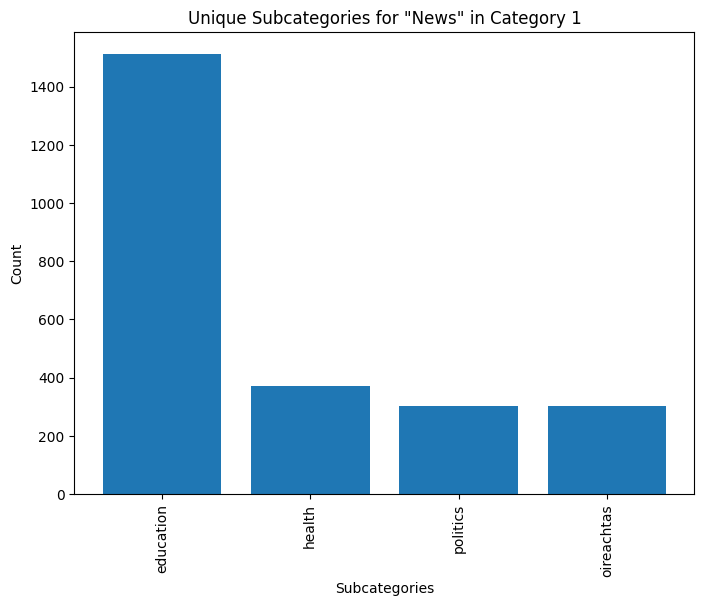

The number of times "Culture" appeared in the data as main category: 2,560
The number of subcategories: 0


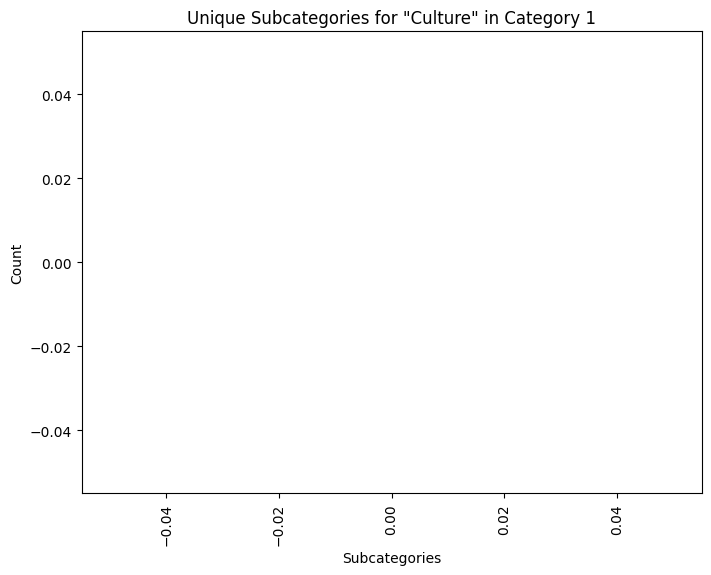

The number of times "Opinion" appeared in the data as main category: 5,407
The number of subcategories: 1


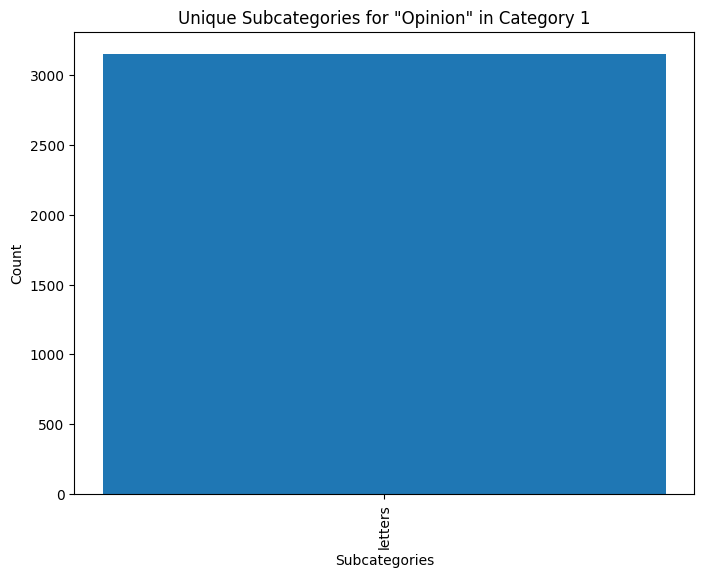

The number of times "Business" appeared in the data as main category: 9,236
The number of subcategories: 0


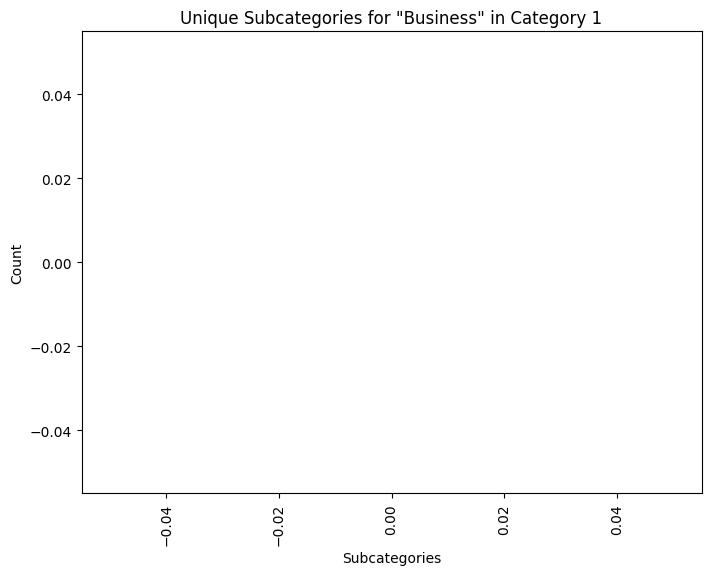

The number of times "Sport" appeared in the data as main category: 9,218
The number of subcategories: 0


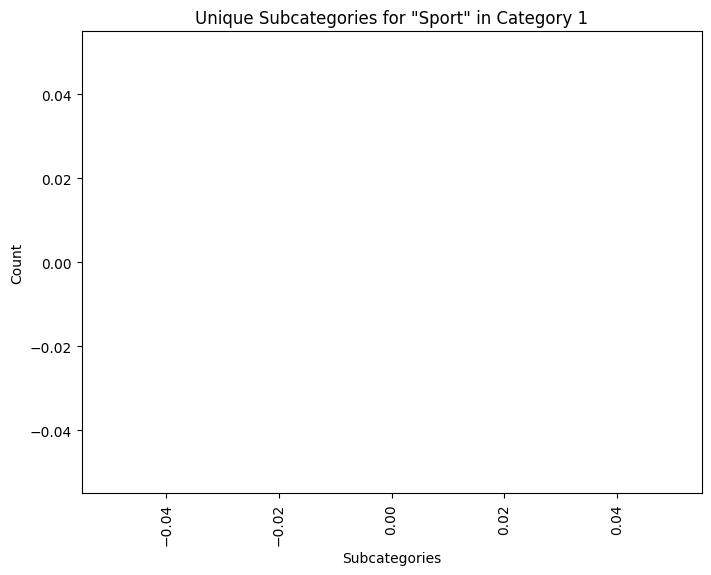

The number of times "Lifestyle" appeared in the data as main category: 2,090
The number of subcategories: 1


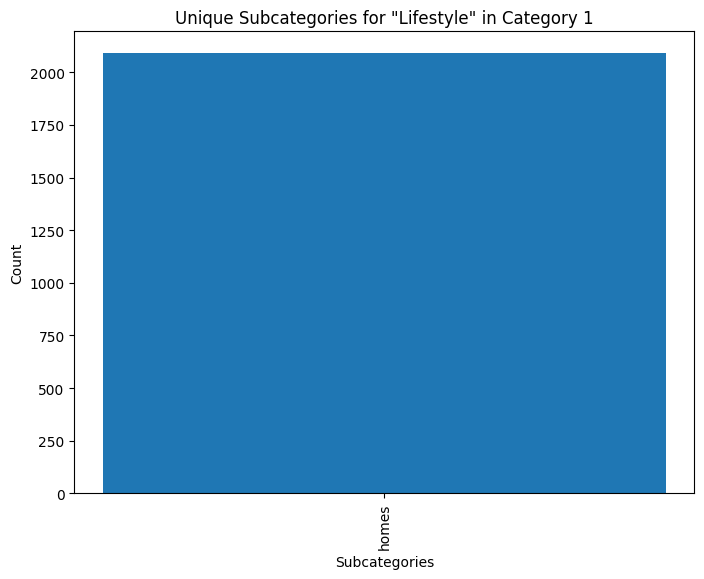

In [ ]:
data_01 = data[data.year==2001]
for main in data_01['category1'].unique():
  sub_per_main(main, data_01)

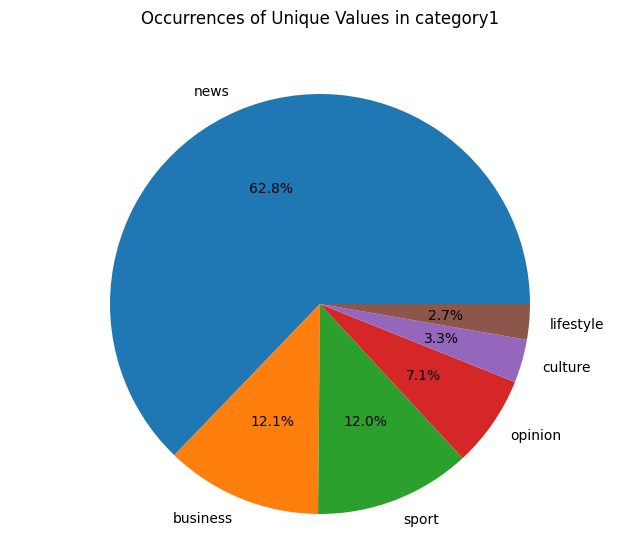

In [ ]:
# plot how many times each of the main categories appears as main
category_counts('category1', data_01)

We are not seeing a specific category that would suggest specifically the 9/11 attacks, but we are able to note that the % of "News" related articles is significantly higher than overall (62.8% vs 49.6%)

---

We want to check which year had the most "Health" related articles (doesn't matter in which column). We would suspect that even though 2020 has the lowest number of articles in a full year (2021 has the lowest but the data stops in June of that year), it would be one of the highest in "Health" related articles cosiderng COVID-19.

In [ ]:
# we already saw that health does not appear in category 1
data[(data.category2=='health')|(data.category3=='health')|(data.category4=='health')]
# after checking we can see that health only appears in category2 so we can ignore the second and third constraints.

,publish_date,headline_category,headline_text,category1,category2,category3,category4,word_count,year
829,1996-01-08,news.health,When abuse is by a woman,news,health,,,6,1996
830,1996-01-08,news.health,Learning how to trust,news,health,,,4,1996
831,1996-01-08,news.health,CHECK UP,news,health,,,2,1996
832,1996-01-08,news.health,Three step approach on how to cope,news,health,,,7,1996
833,1996-01-08,news.health,Hope for ovarian cancer patients,news,health,,,5,1996
...,...,...,...,...,...,...,...,...,...
1611274,2021-06-29,news.health,Stocks of AstraZeneca; J&J for under 40s will ...,news,health,,,12,2021
1611293,2021-06-29,news.health,Woman (80s) dies following two car collision i...,news,health,,,10,2021
1611301,2021-06-29,news.health,Waiting list for cardiac rehab increased by 54...,news,health,,,12,2021
1611406,2021-06-30,news.health,Blood being imported from England due to short...,news,health,,,10,2021


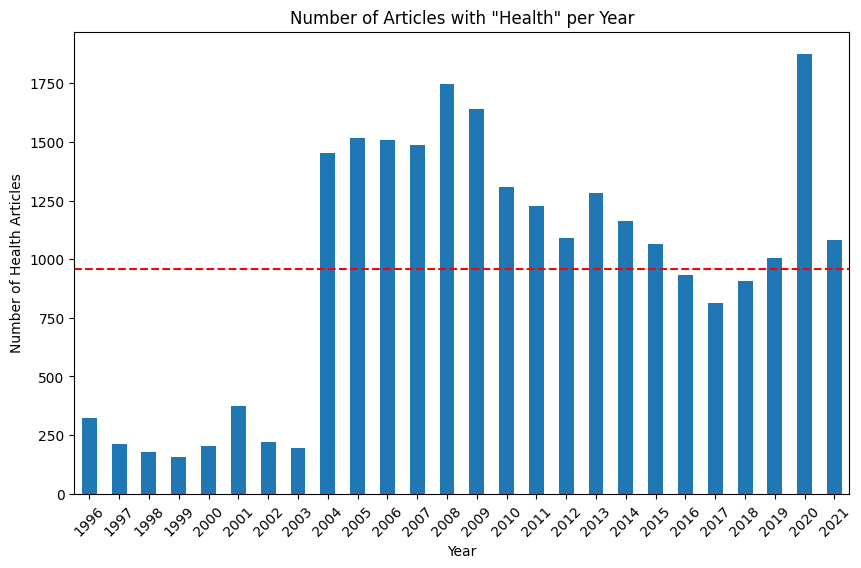

In [ ]:
health_articles = data[data.category2=='health']
# Count the number of health articles for each year
yearly_health_counts = health_articles['year'].value_counts().sort_index()
average_health_articles = yearly_health_counts.mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
yearly_health_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Health Articles')
plt.title('Number of Articles with "Health" per Year')
plt.axhline(average_health_articles, color='r', linestyle='--', label='Average')
plt.xticks(rotation=45)
plt.show()

As we thought, even though 2020 has the lowest number of articles overall, it has the highest number of "Health" related articles. Also interesting - even though 2021 only has half a year of data, it still has a number of "Health" related articles above average.

---

H0: 2020's number of health related articles comes from the same distribution as the rest of the years'.

H1: else.

In [ ]:
from scipy.stats import ks_2samp

# Assuming you have a DataFrame named 'data' with columns 'year' and 'category2'

# Filter the data for the 'health' category in 2020 vs. the rest
health_articles_2020 = health_articles[health_articles.year == 2020]
health_articles_rest = health_articles[~health_articles.year.isin([2020])]

# Get the number of health-related articles in 2020 and the rest of the years
health_counts_2020 = health_articles_2020.groupby('year').size()
health_counts_rest = health_articles_rest.groupby('year').size()

# Perform the Two-Sample Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(health_counts_2020, health_counts_rest)

# Print the test statistic and p-value
print("Test Statistic: ", statistic)
print("P-Value: ", p_value)

Test Statistic:  1.0
P-Value:  0.07692307692307693


In the Two-Sample Kolmogorov-Smirnov test, the p-value represents the probability of obtaining a test statistic as extreme or more extreme than the observed value, assuming the null hypothesis is true. The test statistic measures the maximum vertical distance between the empirical cumulative distribution functions (CDFs) of the two samples.
The test statistic itself does not determine the rejection or acceptance of the null hypothesis. Instead, it provides a measure of the difference between the empirical CDFs of the two samples. A larger test statistic indicates a larger maximum vertical distance between the CDFs, which suggests a greater difference between the distributions.

In this case, since the P-Value is 0.07, we can say that for a significance level (alpha) of 0.1, we will reject H0 and can say that the number of health related articles in 2020 does **not** come from the same distribution as the number of health related articles in the rest of the years.

---

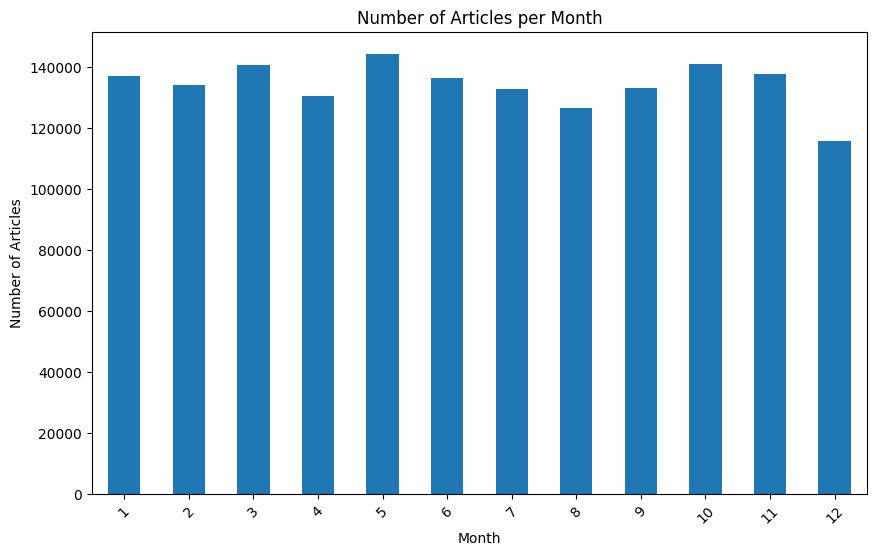

In [ ]:
# monthly analysis
data['month'] = pd.to_datetime(data['publish_date'], format='%Y%m%d').dt.month

# Count the number of rows for each year
monthly_counts = data['month'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Month')
plt.xticks(rotation=45)
plt.show()

Doesn't seem to be a special month. Lets check the topics of articles published in March (March 17 - st. Patrick's day)

In [ ]:
data_march = data[data.month==3]

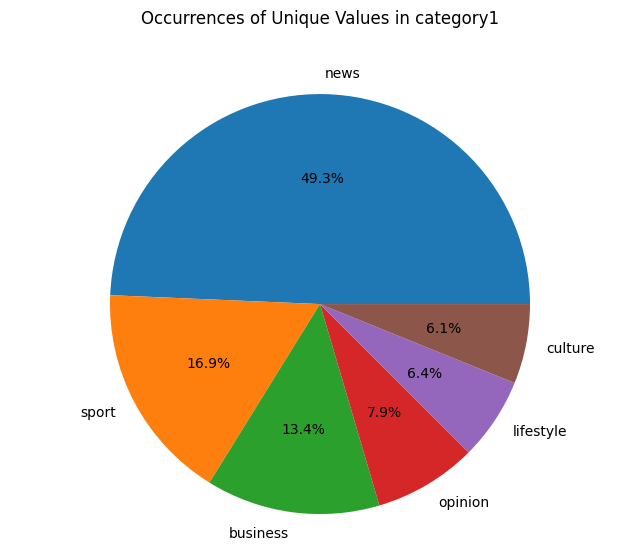

In [ ]:
# main topics
category_counts('category1', data_march)

We would have expected to see a surge in 'Culture' but there isn't a significant difference than usual.

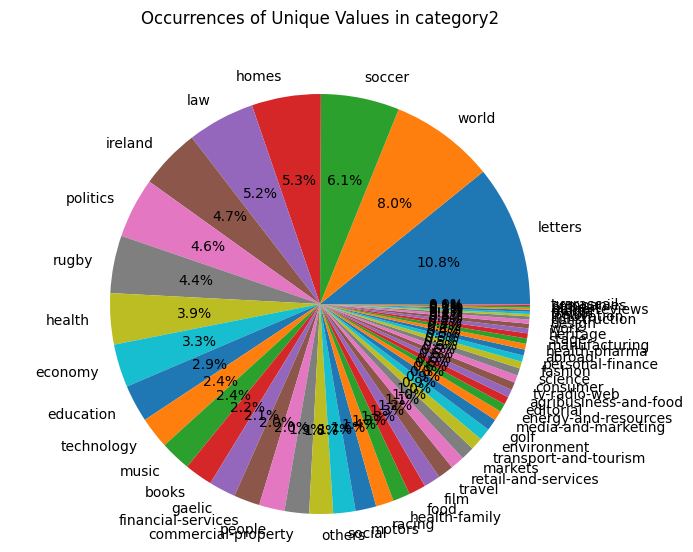

In [ ]:
category_counts('category2', data_march)

Judging by the fact that the top categories don't seem to be related to topics that have to do with st. Patrick's day (even though the chart isn't readable in the smaller categories), we can assume that there isn't a significant amount of st. Patrick related articles around March.